Human Face Emotions,
This dataset contains three folders namely Happy, Sad and Angry. Each folder contains around 100 images of each mentioned expression.

کتابخانه های مورد نیاز

In [1]:
import os
import cv2
import pickle
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


کد cnn

In [19]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # Grayscale images
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjust based on input image size
        self.fc2 = nn.Linear(128, 10)  # Output 10 classes, e.g., for MNIST

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the output from convolution layers
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()


در اینجا برای اینکه تمامی تصاویر را شامل شود بایستی فرمت آن ها را تغییر دهیم

In [4]:
# مسیر به دیتاست
dataset_dir = r'data/'  

# اندازه تصویر
img_size = 150   # 150*150 پیکسل

# لیست‌ها برای ذخیره تصاویر و برچسب‌ها
images = []
labels = []

# لیستی از احساسات صورت انسان 
emotion_labels = {
                   'Happy': 0, 'Sad': 1, 'Angry': 2
                   }

# بارگذاری تصاویر و برچسب‌ها از پوشه‌های مختلف
for emotion, label in emotion_labels.items():
    emotion_folder = os.path.join(dataset_dir, emotion)
    
    # بررسی اینکه پوشه وجود دارد
    if os.path.exists(emotion_folder):  # اگر وجود داشته باشد ادامه می دهد
        #print(f"Folder exists: {emotion_folder}")
        for img_name in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_name)
            
            # چاپ مسیر فایل برای بررسی
            #print(f"Reading image: {img_path}")
            
            # بارگذاری تصویر
            img = cv2.imread(img_path)
            
            # بررسی اگر تصویر بارگذاری نشد
            if img is None:
                #print(f"Warning: Image {img_path} could not be loaded.")
                continue  # ادامه می‌دهیم بدون اینکه به آن تصویر پرداخته شود

            # تغییر اندازه و نرمال‌سازی
            img = cv2.resize(img, (150, 150))  # تغییر اندازه به 150x150
            img = img / 255.0  # نرمال‌سازی تصویر
            
            # افزودن تصویر و برچسب به لیست
            images.append(img)
            labels.append(label)
    
# تبدیل لیست‌ها به آرایه NumPy
images = np.array(images)
labels = np.array(labels)

# تبدیل برچسب‌ها به فرمت one-hot
labels = to_categorical(labels, num_classes=3)

# ذخیره به فرمت pkl
with open('emotion_dataset.pkl', 'wb') as f:
    pickle.dump((images, labels), f)



تعداد تصاویر هر پوشه احساس

In [5]:
for emotion in emotion_labels.keys():
    emotion_folder = os.path.join(dataset_dir, emotion)
    files = os.listdir(emotion_folder)
    print(f"Number of images in {emotion_folder}: {len(files)}")


Number of images in data/Happy: 100
Number of images in data/Sad: 79
Number of images in data/Angry: 86


ابعاد دیتای آموزشی

In [6]:
# بارگذاری داده‌ها از فایل pkl
with open('emotion_dataset.pkl', 'rb') as f:
    train_images, train_labels = pickle.load(f)

# بررسی ابعاد داده‌ها
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)


Train images shape: (264, 150, 150, 3)
Train labels shape: (264, 3)


ساخت مدل cnn

In [7]:
# ساخت مدل CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)), MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'), MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'), MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 کلاس: angry,happy,sad
])

# کامپایل کردن مدل
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# آموزش مدل
model.fit(train_images, train_labels, batch_size=32, epochs=10, validation_split=0.2)


c:\Users\fatem\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 465ms/step - accuracy: 0.4525 - loss: 1.6534 - val_accuracy: 0.0000e+00 - val_loss: 1.1474
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.4786 - loss: 0.9937 - val_accuracy: 0.0000e+00 - val_loss: 1.9387
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.5957 - loss: 0.9062 - val_accuracy: 0.0000e+00 - val_loss: 1.6517
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.7000 - loss: 0.7902 - val_accuracy: 0.0000e+00 - val_loss: 1.6602
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.7087 - loss: 0.7438 - val_accuracy: 0.0189 - val_loss: 2.0211
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.7526 - loss: 0.6285 - val_accuracy: 0.1887 - val_loss: 1.7707
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8140 - loss: 0.4936 - val_accuracy: 0.1698 - val_loss: 1.8351
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step - accuracy: 0.8741 - loss: 0.3332 - val_accuracy: 0.

In [8]:

# تقسیم داده‌ها به آموزش و اعتبارسنجی (80% آموزش، 20% اعتبارسنجی)
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)


In [9]:
model.fit(train_images, train_labels, batch_size=32, epochs=10, validation_data=(val_images, val_labels))
#print("Train images shape:", train_images.shape)
#print("Train labels shape:", train_labels.shape)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 0.7847 - loss: 0.5084 - val_accuracy: 0.9057 - val_loss: 0.4258
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - accuracy: 0.8425 - loss: 0.3972 - val_accuracy: 0.9245 - val_loss: 0.3327
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - accuracy: 0.8944 - loss: 0.2895 - val_accuracy: 0.7358 - val_loss: 0.5101
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.8854 - loss: 0.2889 - val_accuracy: 0.8491 - val_loss: 0.4064
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.9634 - loss: 0.1634 - val_accuracy: 0.8302 - val_loss: 0.3647
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.9434 - loss: 0.1447 - val_accuracy: 0.8302 - val_loss: 0.4690
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step - accuracy: 0.9794 - loss: 0.0900 - val_accuracy: 0.7925 - val_loss: 0.5561
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.9654 - loss: 0.0645 - val_accuracy: 0.8302 - val_loss:

محاسبه دقت مدل

In [10]:
loss, accuracy = model.evaluate(val_images, val_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8243 - loss: 0.5207
Validation Accuracy: 83.02%


ذخیره سازی مدل

In [11]:
model.save('emotion_model.h5')


نمودار

In [12]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=10, validation_data=(val_images, val_labels))


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 562ms/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 0.7925 - val_loss: 0.5984
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 462ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.8491 - val_loss: 0.5546
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - accuracy: 0.9974 - loss: 0.0176 - val_accuracy: 0.7547 - val_loss: 0.7410
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - accuracy: 0.9932 - loss: 0.0455 - val_accuracy: 0.8302 - val_loss: 0.5378
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 1.0000 - loss: 0.0244 - val_accuracy: 0.8113 - val_loss: 0.6789
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.8113 - val_loss: 0.5855
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.8113 - val_loss: 0.6078
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step - accuracy: 0.9988 - loss: 0.0083 - val_accuracy: 0.7925 - val_loss:

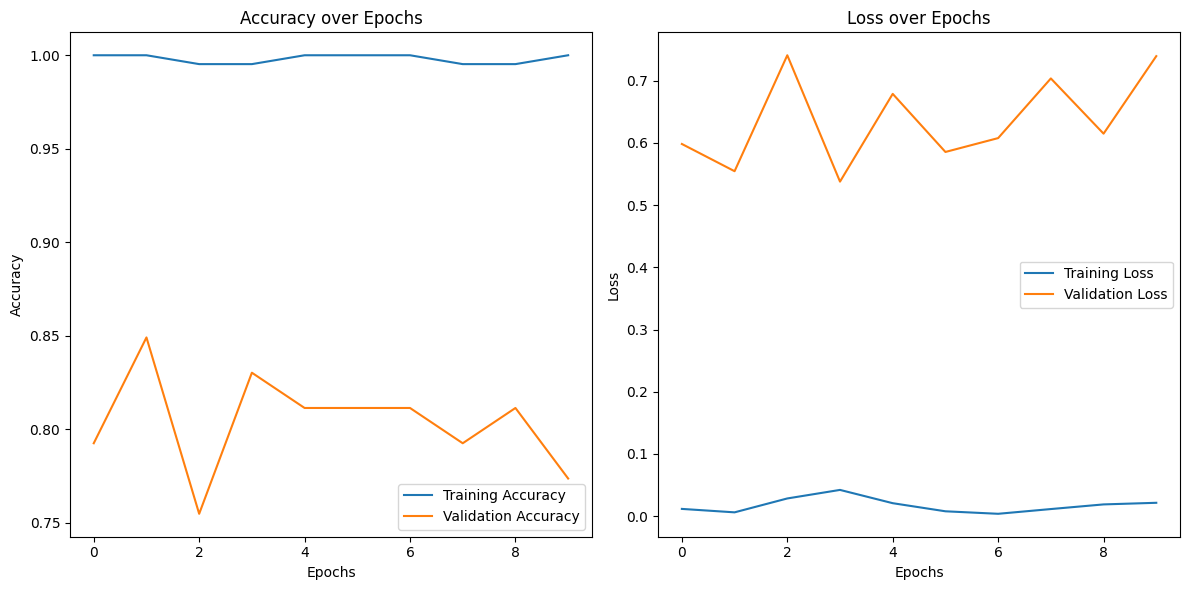

In [13]:

# رسم نمودار دقت
plt.figure(figsize=(12, 6))

# دقت آموزش و اعتبارسنجی
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# رسم نمودار از دست دادن
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# نمایش نمودارها
plt.tight_layout()
plt.show()
